This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2025.1_tutorials/wallaroo-run-anywhere/inference/deploy/edge-unet-brain-segmentation-deploy).

## Wallaroo Edge Deployment & Inference for U-Net Computer Vision for Brain Segmentation

The following example uses the [U-Net for brain segmentation model](https://github.com/mateuszbuda/brain-segmentation-pytorch/tree/master) trained to detect lower-grade gliomas to demonstrate how to:

* Deploy the model into a Wallaroo Ops server.
* Perform a sample inferences via the Wallaroo SDK and the API calls.
* Publish the pipeline to an OCI (Open Container Initiative) registry service.
* Deploy the published pipeline to an edge device as a Wallaroo Inference Server, and perform the same inference calls.

### Prerequisites

* A Wallaroo Community Edition or Enterprise Edition server with Edge Deployment enabled.
  * For a free license of Wallaroo Community Edition, go to [https://portal.wallaroo.community/](https://portal.wallaroo.community/).
* A x64 edge device capable of running Docker

### References

* [Edge Deployment Registry Guide](https://docs.wallaroo.ai/wallaroo-platform-operations/wallaroo-platform-operations-configure/wallaroo-edge-deployment/)
* [Brain MRI segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation): The original evaluation and training images.  These can be used with this inference server.

## Tutorial Steps

### Import Libraries

The first step is to import the libraries we'll be using.  These are included by default in the Wallaroo instance's JupyterHub service.

Verify that the following Python libraries are installed. The `wallaroo` library is included with the Wallaroo Ops JupyterHub instance.

* `pillow`
* `torchvision`
* `pandas`
* `pyarrow`
* `wallaroo`

* References
  * [Wallaroo SDK Install Guides](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-install-guides/)

In [1]:
import wallaroo
from wallaroo.pipeline   import Pipeline
from wallaroo.deployment_config import DeploymentConfigBuilder
from wallaroo.framework import Framework

# used to convert the Image into a numpy array
from PIL import Image
from torchvision import transforms

import pyarrow as pa
import numpy as np
import pandas as pd

import requests

# used to display dataframe information without truncating
from IPython.display import display
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

The option `request_timeout` provides additional time for the Wallaroo model upload process to complete.

In [2]:
wl = wallaroo.Client()

### Create Retrieve WOrkspace and Pipeline

We retrieve the workspace and pipeline used to create the pipeline publish.

The workspace will then be set as the Current Workspace.  Model uploads and pipeline creation through the SDK are set in the current workspace.

* References
  * [Wallaroo SDK Essentials Guide: Workspace Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-workspace/)

In [3]:
workspace_name = "unet-detection-run-anywhere-demonstration"
model_name = "pt-unet"
model_file_name = './models/unet.pt'
pipeline_name = "pt-unet"

workspace = wl.get_workspace(name=workspace_name, create_if_not_exist=True)
wl.set_current_workspace(workspace)

pipeline = wl.get_pipeline(pipeline_name)

### Retrieve Pipeline Publish

We retrieve the pipeline publish details via the pipeline.publishes() method.  We assume that this pipeline only has the one publish created from the previous tutorial run, and display it's details that include the Docker Run command we will use for the deployment step.

In [5]:
pipeline.publishes()

id,pipeline_version_name,engine_url,pipeline_url,created_by,created_at,updated_at
1,18a2e65e-d600-471f-80fe-6b60030f9dda,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.4.0-6077,ghcr.io/wallaroolabs/doc-samples/pipelines/pt-unet:18a2e65e-d600-471f-80fe-6b60030f9dda,john.hansarick@wallaroo.ai,2025-29-Apr 18:51:29,2025-29-Apr 18:51:29


In [6]:
pipeline.publishes()[0]

ID,1
Pipeline Name,pt-unet
Pipeline Version,18a2e65e-d600-471f-80fe-6b60030f9dda
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.4.0-6077
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/pt-unet:18a2e65e-d600-471f-80fe-6b60030f9dda
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/pt-unet
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:ec23c28cc1427076bdab1566b45348f68cc7c46351d5aa49a35c58ee79eec2a7
Helm Chart Version,0.0.1-18a2e65e-d600-471f-80fe-6b60030f9dda
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}, 'arch': 'x86', 'accel': 'none', 'gpu': False}}, 'engineAux': {'autoscale': {'type': 'none'}}}"
User Images,[]


In [17]:
pipeline.publishes()[0].pipeline_url

'ghcr.io/wallaroolabs/doc-samples/pipelines/pt-unet:18a2e65e-d600-471f-80fe-6b60030f9dda'

## DevOps - Pipeline Edge Deployment

Once a pipeline is deployed to the Edge Registry service, it can be deployed in environments such as Docker, Kubernetes, or similar container running services by a DevOps engineer.  For our example, we will use the `docker run` command output during the pipeline publish.

## Edge Deployed Pipeline API Endpoints

Once deployed, we can check the pipelines and models available.  We'll use a `curl` command, but any HTTP based request will work the same way.

The endpoint `/pipelines` returns:

* **id** (*String*):  The name of the pipeline.
* **status** (*String*):  The status as either `Running`, or `Error` if there are any issues.

For this example, the deployment is made on a machine called `testboy.local`.  Replace this URL with the URL of your edge deployment.

In [20]:
deploy_url = 'http://testboy.local:8081/pipelines'

response = requests.get(
                    deploy_url
                )

display(response.json())

{'pipelines': [{'id': 'pt-unet',
   'version': '18a2e65e-d600-471f-80fe-6b60030f9dda',
   'status': 'Running'}]}

### Edge Inference Endpoint

The inference endpoint takes the following pattern:

* `/infer`

Wallaroo inference endpoint URLs accept the following data inputs through the `Content-Type` header:

* `Content-Type: application/vnd.apache.arrow.file`: For Apache Arrow tables.
* `Content-Type: application/json; format=pandas-records`: For pandas DataFrame in record format.

Once deployed, we can perform an inference through the deployment URL.

The endpoint returns `Content-Type: application/json; format=pandas-records` by default with the following fields:

* **time** (*Integer*): The time since UNIX epoch.

* **in**: The original input data.  Returns `null` if the input may be too long for a proper return.
* **out** (*List*): The outputs of the inference result separated by the model's output fields.
* **check_failures** (*List[Integer]*): Whether any validation checks were triggered.  For more information, see [Wallaroo SDK Essentials Guide: Pipeline Management: Anomaly Testing](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/#anomaly-testing).
* **metadata**  (*String*): The metadata including the model name, etc.


For this example, we will use the same DataFrame with the image data and perform the same API inference request, this time through the edge device located at hostname `testboy.local`.  Adjust the URL according to your edge deployment.


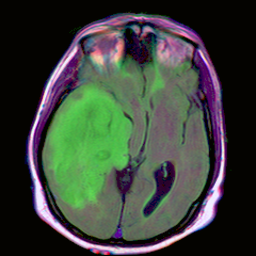

(1, 3, 256, 256)

In [21]:

input_image = Image.open("./data/TCGA_CS_4944.png")
display(input_image)

# preprocess
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

nimage = input_batch.detach().numpy()
nimage.shape

In [22]:
nimage = input_tensor.detach().numpy()

input_data = {
        "input": [nimage]
}
dataframe = pd.DataFrame(input_data)

In [25]:
headers = {
        'Content-Type': 'application/json; format=pandas-records'
    }
# 

deploy_url = 'http://testboy.local:8081/infer'

response = requests.post(
                    deploy_url, 
                    headers=headers, 
                    data=dataframe.to_json(orient="records")
                )

display(pd.DataFrame(response.json()).loc[0, 'out']['output'][0:5])

[1.475215e-05, 1.463294e-05, 1.3977289e-05, 1.3887882e-05, 1.4543533e-05]

### Undeploy Edge Pipeline

To undeploy the edge pipeline, either use `Control-C` from the terminal.  Or, use:

```bash
docker ps

CONTAINER ID   IMAGE                                                                                                      COMMAND                  CREATED         STATUS                 PORTS                                                                                                                                                                         NAMES
690f24d4d9b1   ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.4.0-6077   "/usr/bin/tini -- /s…"   2 seconds ago   Up 1 second            0.0.0.0:8081->8080/tcp, :::8081->8080/tcp                                                                                                                                     nifty_spence

Find the Docker container running.  This example we can see the. `wallaroolabs` image running, and give it the kill command from the container id.  When the image is no longer available with `docker ps`, the edge deployment of Wallaroo Inference Server has stopped.

```bash
docker stop 690f24d4d9b1

docker ps
CONTAINER ID   IMAGE                  COMMAND                  CREATED        STATUS       PORTS                       NAMES
```